# Assemble the catalog of bright missing stars

In [1]:
from astropy.io import fits
import pandas as pd

In [2]:
from pathlib import Path

In [3]:
from importlib import reload
from utils import ks2_utils, shared_utils, image_utils

In [4]:
import re
import numpy as np

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns

In [6]:
figpath = Path("./figs/ks2_bright_stars/")

# INPUT.KS2

In [7]:
ks2_filtermapper = ks2_utils.get_filter_mapper()

In [8]:
ks2_filemapper = ks2_utils.get_file_mapper()

# LOGR.XYVIQ1

LOGR.XYVIQ1 gives the average position for each source on the master frame (cols 1 and 2), the average flux (cols 5 and 11), the flux sigma (cols 6 and 12), and fit quality (cols 7 and 13) in each filter)

This is also known as the "master" catalog

In [9]:
reload(ks2_utils)
mast_cat = ks2_utils.get_master_catalog(raw=False)

In [10]:
mast_cat.head()

,umast0,vmast0,mmast1,NMAST,zmast1,szmast1,q1,o1,f1,g1,zmast2,szmast2,q2,o2,f2,g2
0,736.37,91.51,-2.3045,R0000001,8.352,2.586,0.900,0.01,9,9,14.088,1.538,0.963,0.01,9,9
1,737.04,34.36,-3.2771,R0000002,20.458,2.260,0.899,0.00,9,9,9.987,2.508,0.909,0.00,16,16
2,740.65,61.26,-5.9669,R0000003,243.655,3.332,0.999,0.01,9,9,177.850,2.386,0.999,0.02,9,9
3,745.91,93.19,-2.9646,R0000004,15.340,1.092,0.968,0.01,9,9,19.786,2.601,0.982,0.01,9,9
4,749.93,124.75,-4.4803,R0000005,61.959,3.305,0.997,0.00,9,9,84.200,2.850,0.998,0.00,18,18


# LOGR.FIND_NIMFO


In [11]:
reload(ks2_utils)
ps_cat = ks2_utils.get_point_source_catalog(raw=False)

/Users/jaguilar/miniconda3/envs/astro37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (20,28,34) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [12]:
ps_cat.head(5)

,umast,vmast,magu,utile,vtile,z0,sz0,f0,g0,u1,...,o3,f3,g3,NMAST,ps_tile_id,tile_id,exp_id,filt_id,unk,chip_id
0,736.424,91.482,-2.0238,0.0,0.0,6.5,0.8,0,1,31.849,...,0.0,1,1,R0000001,L005,N001,G004,F1,C,1
1,736.459,91.452,-1.4531,0.0,0.0,3.7,0.8,0,1,31.918,...,0.0,1,1,R0000001,L005,N002,G006,F1,C,1
2,736.323,91.491,-2.5450,0.0,0.0,10.4,0.8,0,1,31.646,...,0.0,1,1,R0000001,L005,N003,G007,F1,C,1
3,736.306,91.445,-2.2584,0.0,0.0,8.3,0.8,0,1,31.611,...,0.0,1,1,R0000001,L005,N004,G009,F1,C,1
4,736.398,91.671,-2.5036,0.0,0.0,9.6,0.8,0,1,31.797,...,0.0,1,1,R0000001,L005,N005,G010,F1,C,1


# Do NOT cut on ndet, q, or z - you need to know if a source has been rejected for some reason

In [13]:
# reload(ks2_utils)
# ps_cat = ks2_utils.catalog_cut_ndet(ps_cat, 10)

In [14]:
# query = ' and '.join([f"z{i} > 0" for i in ks2_utils.phot_method_ids])
# query += 'and ' + ' and '.join([f"q{i} > 0" for i in ks2_utils.phot_method_ids])
# ps_cat = ps_cat.query(query)

# Brightest star in each exposure

In [15]:
exp_gb = ps_cat.groupby("exp_id")
ks2_bright_df = ps_cat.loc[exp_gb['z2'].idxmax()]

In [16]:
# now you have a dataframe of only the brightest point source in each exposure

## Let's test with one exposure

Get the brighest star, and see if you can pick out all the stars brighter than that

In [17]:
import random

In [20]:
row = ks2_bright_df.loc[random.choice(ks2_bright_df.index)]

exp_id = row['exp_id']
print(exp_id)

reload(ks2_utils)
full_img = ks2_utils.get_img_from_ks2_file_id(row['exp_id'])

In [21]:
img_args = {'cmap': mpl.cm.plasma, 
            'norm': mpl.colors.LogNorm(),
           }

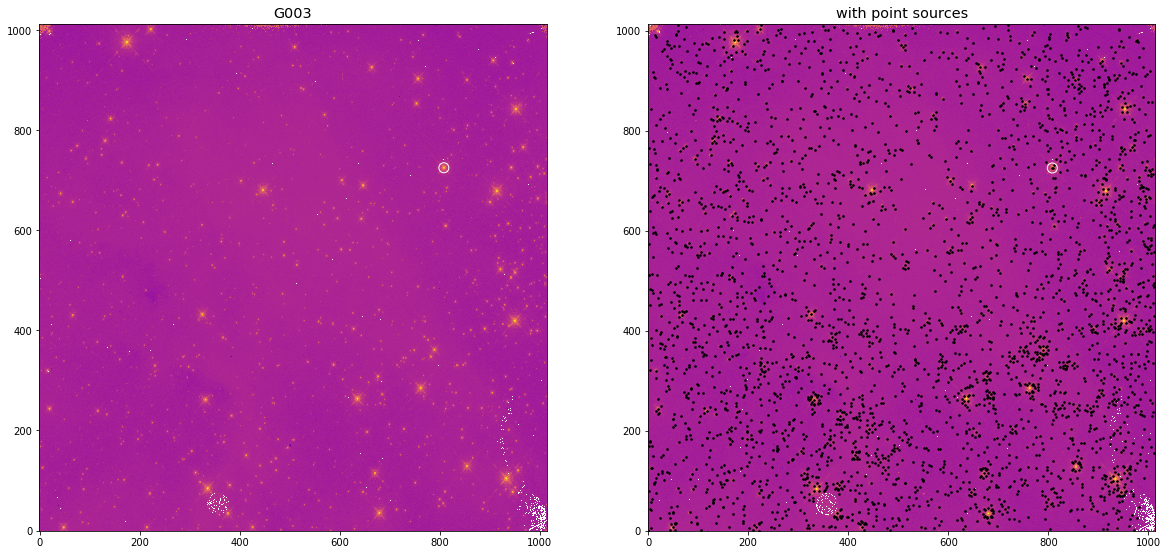

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

ax = axes[0]
ax.set_title(row['exp_id'] )
ax.imshow(full_img, **img_args)
ax.scatter(*row[['xraw1', 'yraw1']]-0.5,
           marker='o', color='none', ec='w', s=100)

ax = axes[1]
ax.set_title('with point sources')
ax.imshow(full_img, **img_args, zorder=-1)
ax.scatter(*row[['xraw1', 'yraw1']]-0.5,
           marker='o', color='none', ec='w', s=100)
exp_df = ps_cat.query('exp_id == @exp_id')
ax.scatter(exp_df['xraw1']-0.5, exp_df['yraw1']-0.5,
           marker='.', color='k', s=10, zorder=0)
ax.set_xlim(0, full_img.shape[1]);
ax.set_ylim(0, full_img.shape[0]);


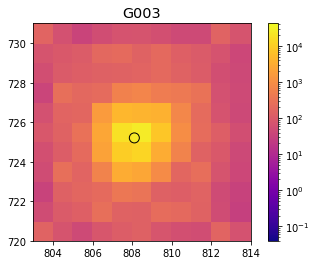

In [23]:
stamp_rad = 11
max_stamp, yx = ks2_utils.get_stamp_from_ks2(row, stamp_rad, True)
# adjust x and y for use with pcolor
y = list(yx[0]) + [yx[0][-1]+1]
x = list(yx[1]) + [yx[1][-1]+1]

fig, ax = plt.subplots(1, 1)
ax.set_title(row['exp_id'])
imax = ax.pcolor(x, y, max_stamp, **img_args)
ax.scatter(*row[['xraw1', 'yraw1']]-0.5,
           marker='o', color='none', ec='k', s=100)
ax.set_aspect('equal')
fig.colorbar(imax)

The maximum detected flux is the max pixel in the stamp?

In [24]:
row[['z0','z1','z2','z3']]

z0    119300
z1    118886
z2    123787
z3    117037
Name: 169894, dtype: object

In [25]:
max_stamp.max()

27175.33984375

# Try again using photutil's source finding algo, using the brightest KS2 source to set the threshold

In [26]:
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder, IRAFStarFinder, find_peaks
from astropy.visualization import SqrtStretch,  LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture

In [46]:
row = ks2_bright_df.loc[random.choice(ks2_bright_df.index)]

exp_id = row['exp_id']
print(exp_id)

reload(ks2_utils)
full_img = ks2_utils.get_img_from_ks2_file_id(row['exp_id'])

G009


In [47]:
mean, median, std = sigma_clipped_stats(full_img, sigma=3.0)  

daofind = DAOStarFinder(fwhm=1.5, threshold=max_stamp.max())  
dao_sources = daofind(full_img - median).to_pandas()

In [48]:
print(dao_sources.shape[0])
dao_sources.head()

10


,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
0,1,410.712073,446.984453,0.844798,-0.045976,0.015108,25,0.0,37481.843750,1.162458,-0.163443
1,2,281.878336,450.948780,0.967866,0.033843,0.041531,25,0.0,36465.421875,1.140285,-0.142534
2,3,367.007435,640.915853,0.964653,0.039101,0.058093,25,0.0,35977.933594,1.132861,-0.135442
3,4,29.664103,684.090502,0.882997,-0.062693,-0.021096,25,0.0,37334.222656,1.167245,-0.167906
4,5,617.215293,710.475272,0.680165,-0.193893,0.072056,25,0.0,37338.253906,1.126317,-0.129151


In [51]:
%matplotlib inline

(0, 1014)

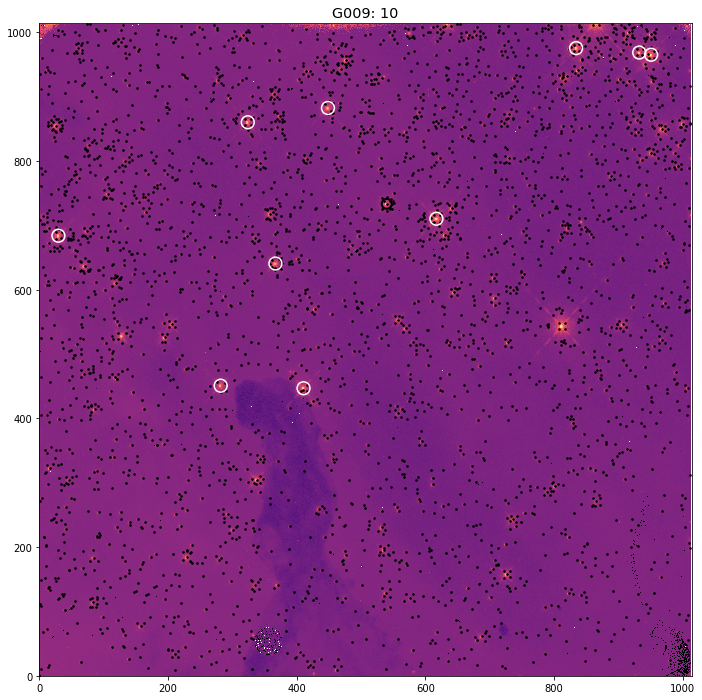

In [52]:
positions = np.transpose((dao_sources['xcentroid'], dao_sources['ycentroid']))
apertures = CircularAperture(positions, r=10.)
norm = ImageNormalize(stretch=LogStretch())

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.set_title(f"{exp_id}: {len(dao_sources)}")

ax.imshow(full_img, origin='lower', norm=mpl.colors.LogNorm())
apertures.plot(color='w', lw=1.5, alpha=1)

# brightest KS2 source
ax.scatter(*row[['xraw1', 'yraw1']]-0.5,
           marker='o', color='none', ec='k', lw=2, s=100)
# all ks2 point sources
exp_df = ps_cat.query('exp_id == @exp_id')
ax.scatter(exp_df['xraw1']-0.5, exp_df['yraw1']-0.5,
           marker='.', color='k', s=10)


ax.set_xlim(0, full_img.shape[1])
ax.set_ylim(0, full_img.shape[0])

# OK, let's do this for every frame

In [37]:
%matplotlib agg

In [43]:
plt.close('all')

In [45]:
bright_df = []
for i, b_row in ks2_bright_df.iterrows():
    exp_id =  b_row['exp_id']
    exp_df = ps_cat.query('exp_id == @exp_id')

    full_img = ks2_utils.get_img_from_ks2_file_id(b_row['exp_id'])
    mean, median, std = sigma_clipped_stats(full_img, sigma=3.0)  

    daofind = DAOStarFinder(fwhm=1.5, threshold=max_stamp.max())  
    dao_sources = daofind(full_img - median).to_pandas()
    dao_sources['exp_id'] = exp_id
    bright_df.append(dao_sources)

    # now make a plot
    positions = np.transpose((dao_sources['xcentroid'], dao_sources['ycentroid']))
    apertures = CircularAperture(positions, r=10.)

    fig, ax = plt.subplots(1, 1, figsize=(12, 12))

    ax.set_title(f"{exp_id}: {len(dao_sources)}")
    ax.imshow(full_img, origin='lower', norm=mpl.colors.LogNorm())
    apertures.plot(color='w', lw=1.5, alpha=1)

    # brightest KS2 source
    ax.scatter(*b_row[['xraw1', 'yraw1']]-0.5,
               marker='o', color='none', ec='k', lw=2, s=100)
    # all ks2 point sources
    exp_df = ps_cat.query('exp_id == @exp_id')
    ax.scatter(exp_df['xraw1']-0.5, exp_df['yraw1']-0.5,
               marker='.', color='k', s=10)

    ax.set_xlim(0, full_img.shape[1])
    ax.set_ylim(0, full_img.shape[0])

    fig.savefig(figpath / f"dao_bright_sources-{exp_id}.png")
    plt.close(fig)
    
bright_df = pd.concat(bright_df)

# Use the other FLT hdus to select the saturated pixels

In [117]:
from utils import header_utils

In [118]:
rootname = re.search('^[a-z0-9]+(?=_flt)', ks2_utils.get_file_name_from_ks2id(exp_id)).group()

In [119]:
dq_hdrs = header_utils.load_headers('dq')

In [120]:
dq_row = dq_hdrs.query('rootname == @rootname').squeeze()

In [124]:
all_imgs = {hdr.lower(): ks2_utils.get_img_from_ks2_file_id(exp_id, hdr) for hdr in header_utils.extnames}

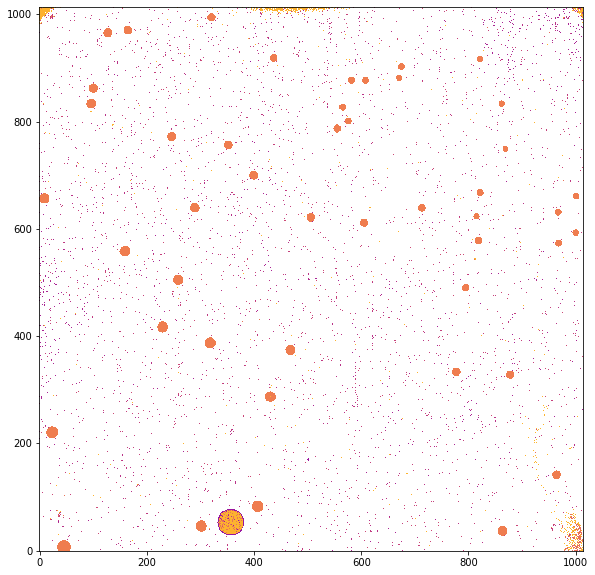

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(all_imgs['dq'], **img_args)

In [133]:
from utils import wfc3_utils

In [394]:
reload(wfc3_utils)
wfc3_utils.dq_flag_parser(np.sum(wfc3_utils.dq_flags))

{0: False,
 1: True,
 2: True,
 4: True,
 8: True,
 16: True,
 32: True,
 64: True,
 128: True,
 256: True,
 512: True,
 1024: True,
 2048: True,
 4096: True,
 8192: True,
 16384: True}

In [395]:
y, x = np.indices(dq_img.shape)
dq_df = pd.DataFrame(zip(x.ravel(), y.ravel(), dq_img.ravel()), 
                     columns=['x', 'y', 'flags'], 
                     dtype=np.int)
for key in wfc3_utils.dq_flags_keys:
    dq_df[key] = ''

In [396]:
dq_df.loc[:, wfc3_utils.dq_flags_keys] = pd.concat([pd.Series(i) for i in dq_df.apply(lambda x: wfc3_utils.dq_int2flag(x['flags']), axis=1)],
                                                    axis=1).T

In [397]:
dq_df.head()

,x,y,flags,16384,8192,4096,2048,1024,512,256,128,64,32,16,8,4,2,1,0
0,0,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,1,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,2,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
3,3,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,4,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


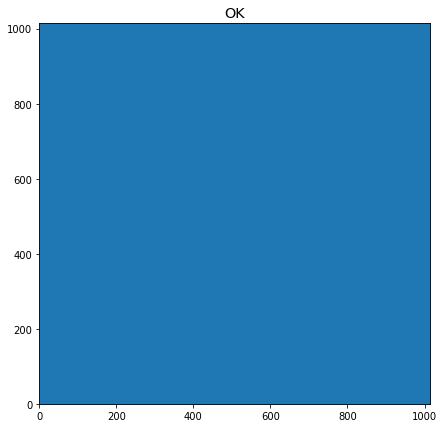

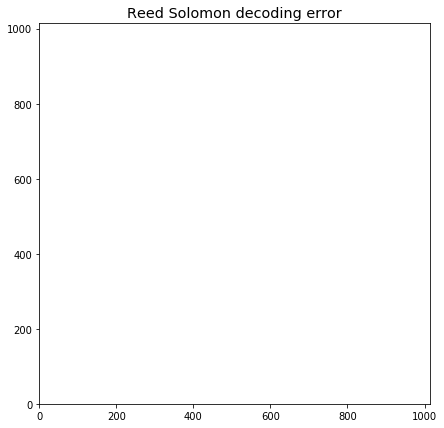

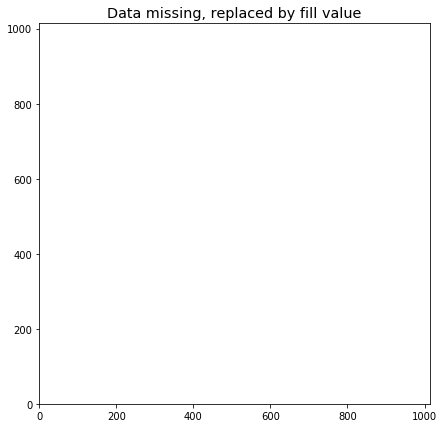

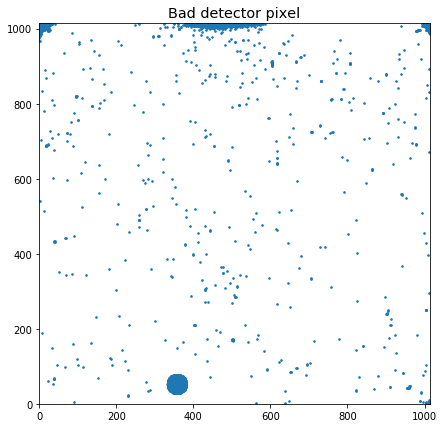

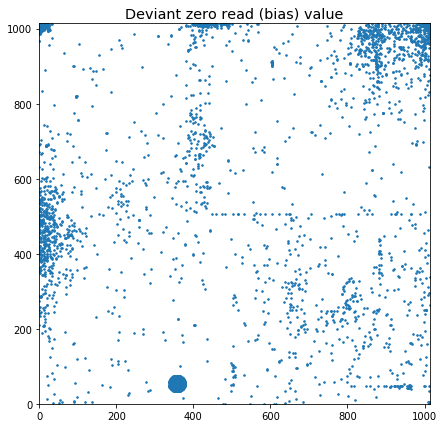

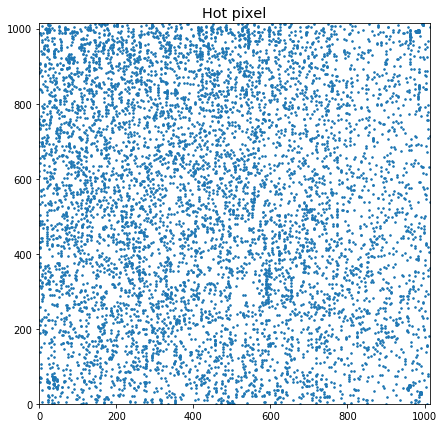

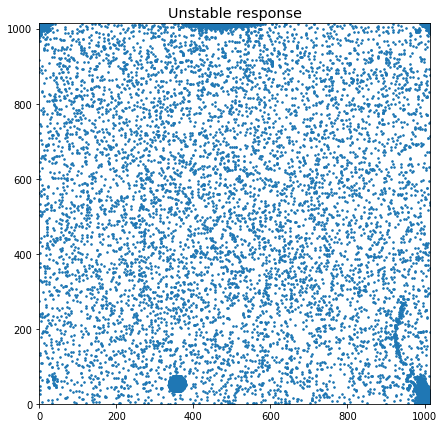

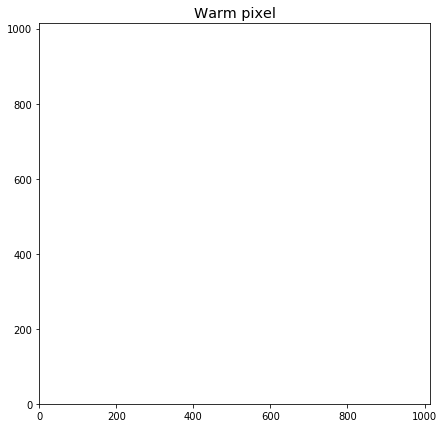

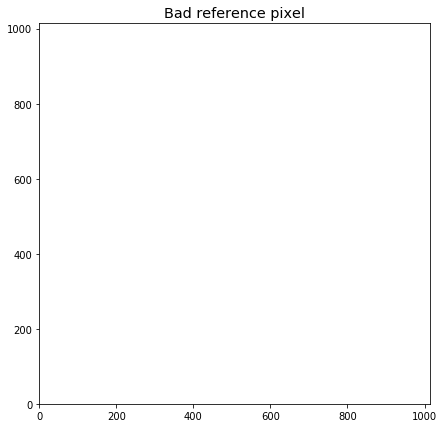

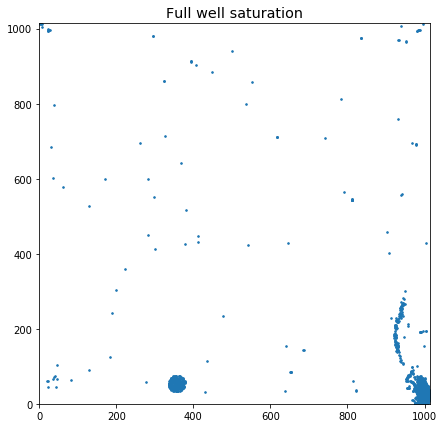

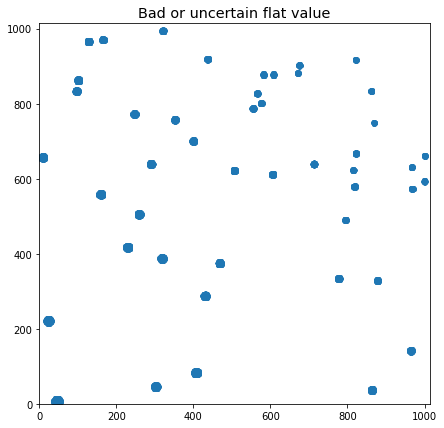

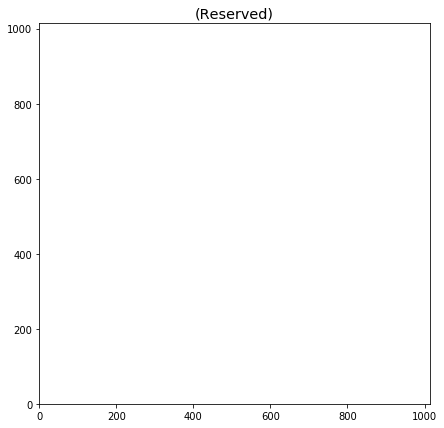

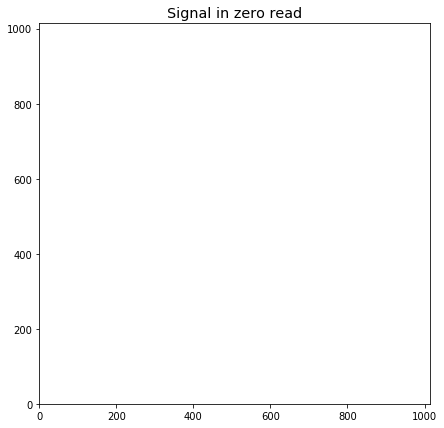

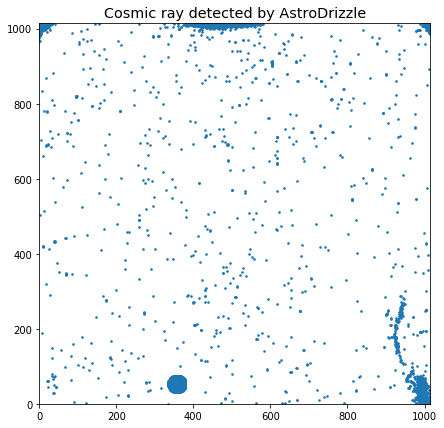

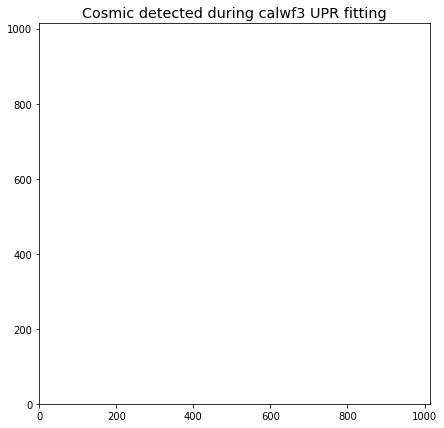

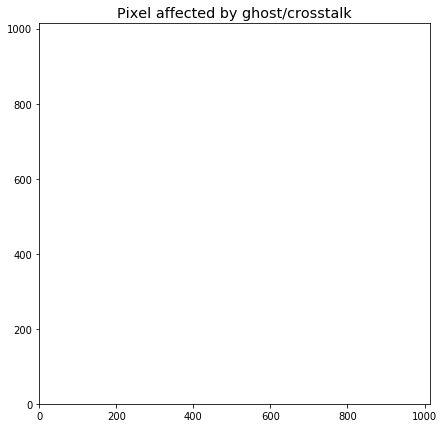

In [310]:
# Plot a map of each flag
reload(wfc3_utils)
plt.close('all')

for flag in wfc3_utils.dq_flags[::-1]:
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    
    ax.set_title(wfc3_utils.dq_flags_descr[flag])
    
    flag_df = dq_df[dq_df[flag]]
    ax.scatter(flag_df['x'], flag_df['y'], 
               marker='.', s=10, 
               label=flag)
    
    ax.set_xlim(0, dq_img.shape[1])
    ax.set_ylim(0, dq_img.shape[0])

(0, 1014)

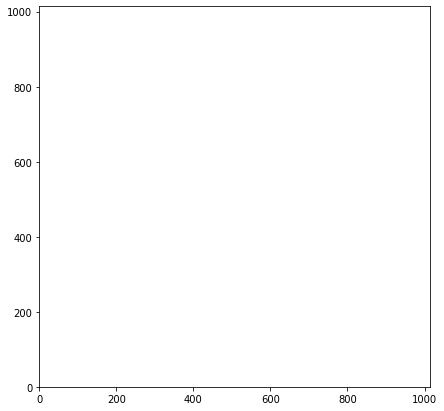

In [331]:
sat_key = 256

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

flags = dq_df[sat_key] & ~dq_df[4096] & dq_df[2048]
flag_df = dq_df[flags]

ax.scatter(flag_df['x'], flag_df['y'], 
           marker='.', s=10, 
           label=flag)

ax.set_xlim(0, dq_img.shape[1])
ax.set_ylim(0, dq_img.shape[0])

In [324]:
samp_img = all_imgs['samp']

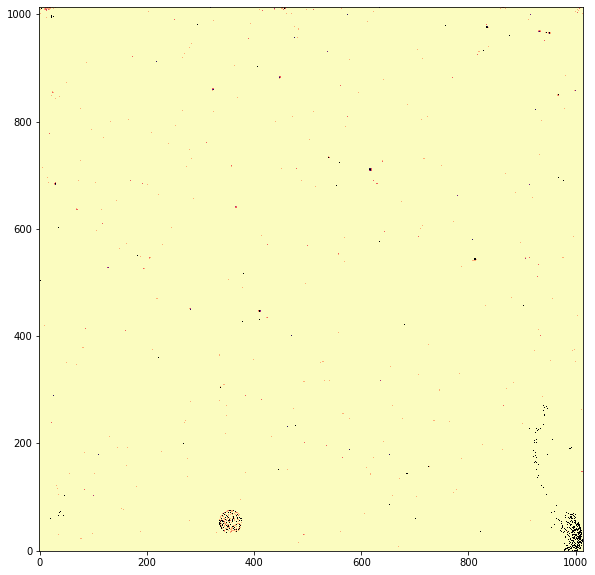

In [330]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(samp_img)

In [361]:
reload(wfc3_utils)
tmp = wfc3_utils.dq_flag_df_parser(11)#np.sum(wfc3_utils.dq_flags))

In [362]:
tmp

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 True]

In [373]:
wfc3_utils.dq_flags_df.set_index("flag")['descr'].to_dict()

{16384: 'Pixel affected by ghost/crosstalk',
 8192: 'Cosmic detected during calwf3 UPR fitting',
 4096: 'Cosmic ray detected by AstroDrizzle',
 2048: 'Signal in zero read',
 1024: '(Reserved)',
 512: 'Bad or uncertain flat value',
 256: 'Full well saturation',
 128: 'Bad reference pixel',
 64: 'Warm pixel',
 32: 'Unstable response',
 16: 'Hot pixel',
 8: 'Deviant zero read (bias) value',
 4: 'Bad detector pixel',
 2: 'Data missing, replaced by fill value',
 1: 'Reed Solomon decoding error',
 0: 'OK'}

In [ ]:
wfc3_utils.dq_flags_df.loc[tmp].to_dict